In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Đồ án biểu diễn (Dự báo giá chứng khoán)/dataset/VNM.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-12-01,20.879999,20.980000,20.750000,20.799999,20.696852,195600
1,2021-12-02,20.799999,20.850000,20.680000,20.719999,20.617249,296800
2,2021-12-03,20.500000,20.549999,20.280001,20.370001,20.268986,251000
3,2021-12-06,20.000000,20.049999,19.870001,20.010000,19.910770,502800
4,2021-12-07,20.379999,20.559999,20.320000,20.510000,20.408291,339700


In [ ]:
from collections import deque
import random

class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 128
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.compat.v1.reset_default_graph()
        self.INITIAL_FEATURES = np.zeros((4, self.state_size))
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, self.state_size))
        self.Y = tf.compat.v1.placeholder(tf.float32, (None, None, self.state_size))
        self.hidden_layer = tf.compat.v1.placeholder(tf.float32, (None, 2 * self.LAYER_SIZE))
        self.ACTION = tf.compat.v1.placeholder(tf.float32, (None))
        self.REWARD = tf.compat.v1.placeholder(tf.float32, (None))
        self.batch_size = tf.shape(input=self.ACTION)[0]
        self.seq_len = tf.shape(input=self.X)[1]

        with tf.compat.v1.variable_scope('curiosity_model'):
            action = tf.reshape(self.ACTION, (-1,1,1))
            repeat_action = tf.tile(action, [1,self.seq_len,1])
            state_action = tf.concat([self.X, repeat_action], axis=-1)
            save_state = tf.identity(self.Y)
            cell = tf.compat.v1.nn.rnn_cell.LSTMCell(self.LAYER_SIZE, state_is_tuple = False)
            self.rnn,last_state = tf.compat.v1.nn.dynamic_rnn(inputs=state_action,cell=cell,
                                                    dtype=tf.float32,
                                                    initial_state=self.hidden_layer)
            self.curiosity_logits = tf.compat.v1.layers.dense(self.rnn[:,-1], self.state_size)
            self.curiosity_cost = tf.reduce_sum(input_tensor=tf.square(save_state[:,-1] - self.curiosity_logits), axis=1)

            self.curiosity_optimizer = tf.compat.v1.train.RMSPropOptimizer(self.LEARNING_RATE)\
            .minimize(tf.reduce_mean(input_tensor=self.curiosity_cost))

        total_reward = tf.add(self.curiosity_cost, self.REWARD)

        with tf.compat.v1.variable_scope("q_model"):
            with tf.compat.v1.variable_scope("eval_net"):
                cell = tf.compat.v1.nn.rnn_cell.LSTMCell(self.LAYER_SIZE, state_is_tuple = False)
                rnn,self.last_state = tf.compat.v1.nn.dynamic_rnn(inputs=self.X,cell=cell,
                                                    dtype=tf.float32,
                                                    initial_state=self.hidden_layer)
                self.logits = tf.compat.v1.layers.dense(rnn[:,-1], self.OUTPUT_SIZE)

            with tf.compat.v1.variable_scope("target_net"):
                cell = tf.compat.v1.nn.rnn_cell.LSTMCell(self.LAYER_SIZE, state_is_tuple = False)
                rnn,last_state = tf.compat.v1.nn.dynamic_rnn(inputs=self.Y,cell=cell,
                                                    dtype=tf.float32,
                                                    initial_state=self.hidden_layer)
                y_q = tf.compat.v1.layers.dense(rnn[:,-1], self.OUTPUT_SIZE)

            q_target = total_reward + self.GAMMA * tf.reduce_max(input_tensor=y_q, axis=1)
            action = tf.cast(self.ACTION, tf.int32)
            action_indices = tf.stack([tf.range(self.batch_size, dtype=tf.int32), action], axis=1)
            q = tf.gather_nd(params=self.logits, indices=action_indices)
            self.cost = tf.compat.v1.losses.mean_squared_error(labels=q_target, predictions=q)
            self.optimizer = tf.compat.v1.train.RMSPropOptimizer(self.LEARNING_RATE).minimize(
            self.cost, var_list=tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, "q_model/eval_net"))

        t_params = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='q_model/target_net')
        e_params = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='q_model/eval_net')
        self.target_replace_op = [tf.compat.v1.assign(t, e) for t, e in zip(t_params, e_params)]

        self.sess = tf.compat.v1.InteractiveSession()
        self.sess.run(tf.compat.v1.global_variables_initializer())

    def _memorize(self, state, action, reward, new_state, done, rnn_state):
        self.MEMORIES.append((state, action, reward, new_state, done, rnn_state))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        actions = np.array([a[1] for a in replay])
        rewards = np.array([a[2] for a in replay])
        new_states = np.array([a[3] for a in replay])
        init_values = np.array([a[-1] for a in replay])
        if (self.T_COPY + 1) % self.COPY == 0:
            self.sess.run(self.target_replace_op)

        cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict = {
            self.X: states, self.Y: new_states, self.ACTION: actions, self.REWARD: rewards,
            self.hidden_layer: init_values
        })

        if (self.T_COPY + 1) % self.COPY == 0:
            self.sess.run(self.curiosity_optimizer, feed_dict = {
                self.X: states, self.Y: new_states, self.ACTION: actions, self.REWARD: rewards,
                self.hidden_layer: init_values
            })
        return cost

    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        init_value = np.zeros((1, 2 * self.LAYER_SIZE))
        for k in range(self.INITIAL_FEATURES.shape[0]):
            self.INITIAL_FEATURES[k,:] = state
        for t in range(0, len(self.trend) - 1, self.skip):

            if np.random.rand() < self.EPSILON:
                action = np.random.randint(self.OUTPUT_SIZE)
            else:
                action, last_state = self.sess.run([self.logits,
                                                  self.last_state],
                                                  feed_dict={self.X:[self.INITIAL_FEATURES],
                                                             self.hidden_layer:init_value})
                action, init_value = np.argmax(action[0]), last_state

            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )

            new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
            self.INITIAL_FEATURES = new_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            init_value = np.zeros((1, 2 * self.LAYER_SIZE))
            for k in range(self.INITIAL_FEATURES.shape[0]):
                self.INITIAL_FEATURES[k,:] = state
            for t in range(0, len(self.trend) - 1, self.skip):
                if np.random.rand() < self.EPSILON:
                    action = np.random.randint(self.OUTPUT_SIZE)
                else:
                    action, last_state = self.sess.run([self.logits,
                                                  self.last_state],
                                                  feed_dict={self.X:[self.INITIAL_FEATURES],
                                                             self.hidden_layer:init_value})
                    action, init_value = np.argmax(action[0]), last_state

                next_state = self.get_state(t + 1)

                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]

                invest = ((starting_money - initial_money) / initial_money)
                new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
                self._memorize(self.INITIAL_FEATURES, action, invest, new_state,
                               starting_money < initial_money, init_value[0])
                self.INITIAL_FEATURES = new_state
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                cost = self._construct_memories(replay)
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [ ]:
tf.compat.v1.disable_eager_execution()

In [ ]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size,
              window_size = window_size,
              trend = close,
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCe

epoch: 10, total rewards: -32.350000.3, cost: 0.208153, total money: 9910.900000
epoch: 20, total rewards: -19.810003.3, cost: 0.545416, total money: 9968.619997
epoch: 30, total rewards: -16.009999.3, cost: 0.135070, total money: 9961.700001
epoch: 40, total rewards: -10.950009.3, cost: 0.777987, total money: 9966.499991
epoch: 50, total rewards: -60.009983.3, cost: 0.175094, total money: 9811.710017
epoch: 60, total rewards: -24.339998.3, cost: 0.450762, total money: 9940.770002
epoch: 70, total rewards: -57.889999.3, cost: 0.370014, total money: 9733.070001
epoch: 80, total rewards: -32.959989.3, cost: 0.619236, total money: 9899.500011
epoch: 90, total rewards: -54.660004.3, cost: 0.511524, total money: 9841.659996
epoch: 100, total rewards: -20.940003.3, cost: 0.438672, total money: 9979.059997
epoch: 110, total rewards: -58.869999.3, cost: 0.149066, total money: 9672.000001
epoch: 120, total rewards: -20.430004.3, cost: 0.532310, total money: 9979.569996
epoch: 130, total rewards

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 20.719999, total balance 9979.280001
day 2: buy 1 unit at price 20.370001, total balance 9958.910000
day 3: buy 1 unit at price 20.010000, total balance 9938.900000
day 4: buy 1 unit at price 20.510000, total balance 9918.390000
day 5: buy 1 unit at price 20.700001, total balance 9897.689999
day 7: buy 1 unit at price 20.680000, total balance 9877.009999
day 8: buy 1 unit at price 20.680000, total balance 9856.329999
day 9: buy 1 unit at price 20.690001, total balance 9835.639998
day 10, sell 1 unit at price 20.740000, investment 0.096530 %, total balance 9856.379998,
day 11: buy 1 unit at price 20.709999, total balance 9835.669999
day 12: buy 1 unit at price 20.770000, total balance 9814.899999
day 13: buy 1 unit at price 20.600000, total balance 9794.299999
day 14: buy 1 unit at price 20.879999, total balance 9773.420000
day 15, sell 1 unit at price 20.990000, investment 3.043687 %, total balance 9794.410000,
day 16: buy 1 unit at price 20.660000, total bal

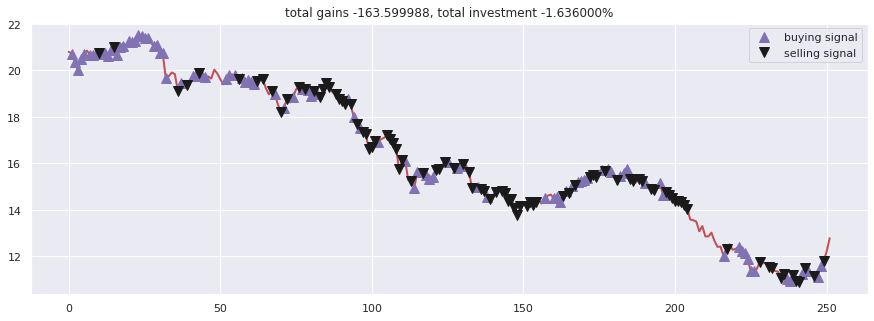

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()